<a href="https://colab.research.google.com/github/Termote/2022/blob/main/Coursework_8_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow_datasets
!pip install -q --no-deps tensorflow-addons~=0.7

!pip install typeguard

import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Reshape, Conv2DTranspose, Dropout, Concatenate
from tensorflow.keras.layers import Reshape, MaxPooling2D, Softmax, Lambda
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# load data from faces_dataset.npz
data = np.load('faces_dataset.npz')
x_train = data['train_data']
y_train = data['train_label']
x_test = data['test_data']
y_test = data['test_label']

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

num_classes = np.max(y_train) + 1

output_train_class_onehot = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
output_test_class_onehot = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

x_train shape: (1360, 128, 128)
y_train shape: (1360,)
x_test shape: (340, 128, 128)
y_test shape: (340,)


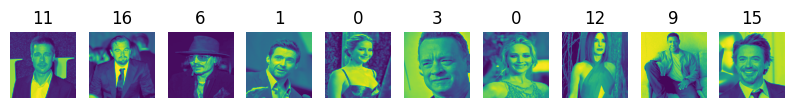

In [3]:

# display the first 10 images in the training set
fig = plt.figure(figsize=(10, 10))
for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    ax.imshow(x_train[i])
    ax.set_title(y_train[i])
    ax.axis('off')
plt.show()

In [ ]:
# Create image pairs for training the discriminator, with labels indicating if they are the same person or not (-1 for different, 1 for same)

size_factor = 3  # reduce the number of pairs to speed up training
nb_pairs = int(len(x_train) * size_factor)

def create_pairs(x, y):
    pairs = []
    labels = []

    # iterate over all images and create nb_pairs matching and non-matching pairs
    for i in range(nb_pairs):
        # select a random image
        idx1 = np.random.randint(0, len(x))
        img1 = x[idx1]
        label1 = y[idx1]

        # select a random image with the same label
        idx2 = np.random.randint(0, len(x))
        while y[idx2] != label1:
            idx2 = np.random.randint(0, len(x))
        img2 = x[idx2]

        # add the pair and the label to the list
        pairs += [np.stack((img1, img2), axis=2)] 
        labels += [1]

        # select a random image with a different label
        idx2 = np.random.randint(0, len(x))
        while y[idx2] == label1:
            idx2 = np.random.randint(0, len(x))
        img2 = x[idx2]

        # add the pair and the label to the list
        pairs += [np.stack((img1, img2), axis=2)]
        labels += [0]

    print('pairs created: ', len(pairs), " size in MB: ", len(pairs) * 2 * 8 * 128 * 128 * 1 / 1024 / 1024)
    labels = tf.keras.utils.to_categorical(labels, 2)  # create one-hot encoded class

    
    return np.array(pairs), np.array(labels)

pairs_train, labels_train = create_pairs(x_train, y_train)
pairs_test, labels_test = create_pairs(x_test, y_test)

print('\npairs_train shape:', pairs_train.shape)
print('labels_train shape:', labels_train.shape)
print('pairs_test shape:', pairs_test.shape)
print('labels_test shape:', labels_test.shape)

print("\nnumber of training matching pairs: ", np.sum(labels_train == 1), " number of non-matching pairs: ", np.sum(labels_train == 0))
print("number of test matching pairs: ", np.sum(labels_test == 1), " number of non-matching pairs: ", np.sum(labels_test == 0))

pairs created:  8160  size in MB:  2040.0
pairs created:  8160  size in MB:  2040.0

pairs_train shape: (8160, 128, 128, 2)
labels_train shape: (8160, 2)
pairs_test shape: (8160, 128, 128, 2)
labels_test shape: (8160, 2)

number of training matching pairs:  8160  number of non-matching pairs:  8160
number of test matching pairs:  8160  number of non-matching pairs:  8160


<ipython-input-14-5a8dc88e3221>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 10], [0, 0], 'k-', lw=2, color='black')


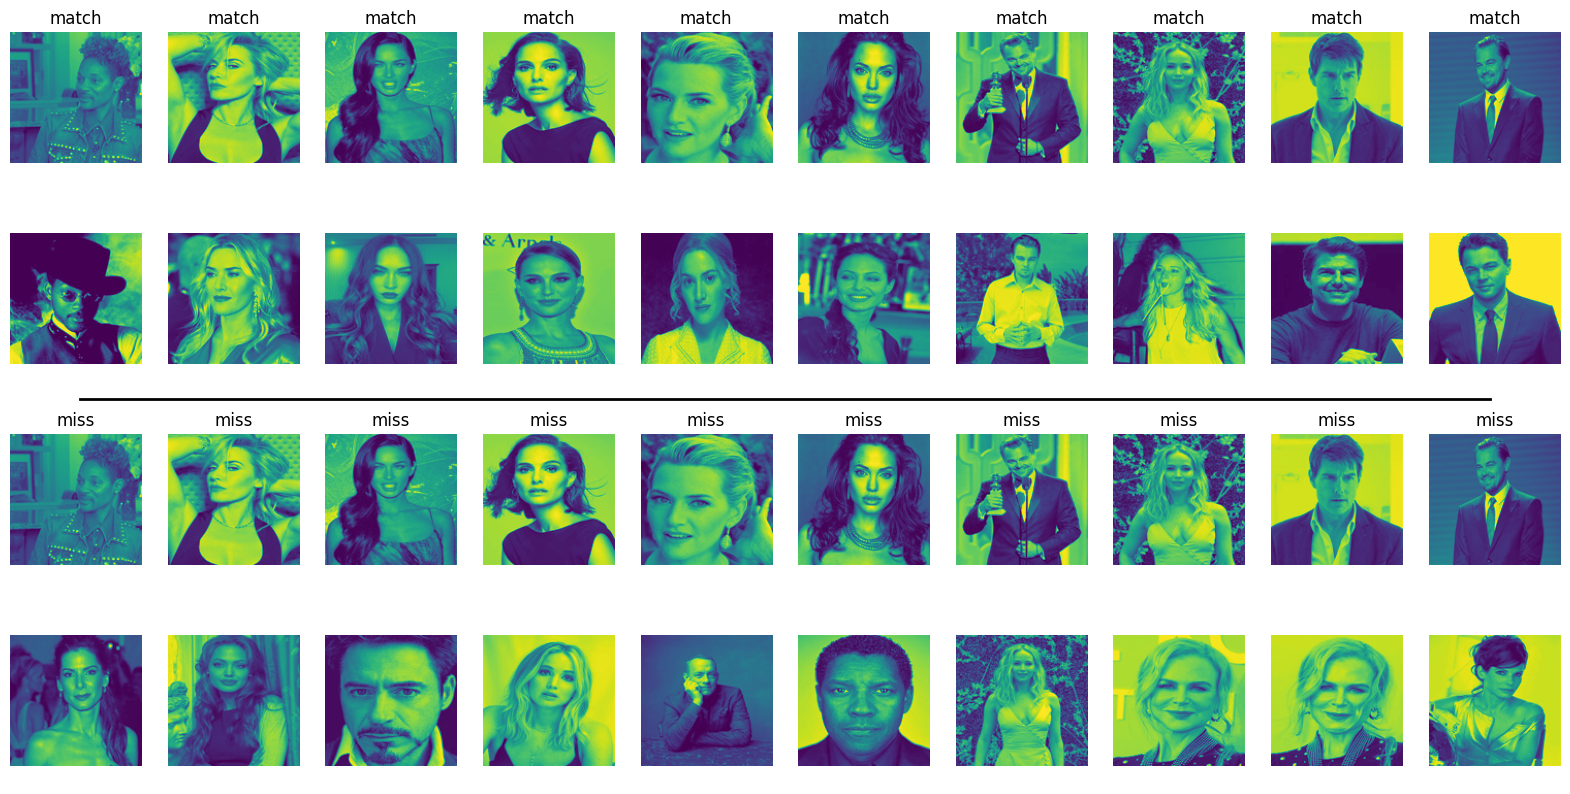

In [ ]:
# plots 10 match examples, and 10 misses examples

fig = plt.figure(figsize=(20, 10))

matches = np.where(labels_train[:,1]==1)[0]
misses = np.where(labels_train[:,1]==0)[0]

plt.plot([0, 10], [0, 0], 'k-', lw=2, color='black')
plt.axis('off')

for i in range(10):
    ax = fig.add_subplot(4, 10, i+1)
    ax.imshow(pairs_train[matches[i],:,:,0])
    ax.set_title('match')
    ax.axis('off')
    ax = fig.add_subplot(4, 10, i+11)
    ax.imshow(pairs_train[matches[i],:,:,1])
    ax.axis('off')

    ax = fig.add_subplot(4, 10, i+21)
    ax.imshow(pairs_train[misses[i],:,:,0])
    ax.set_title('miss')
    ax.axis('off')

    ax = fig.add_subplot(4, 10, i+31)
    ax.imshow(pairs_train[misses[i],:,:,1])
    ax.axis('off')

plt.show()


In [ ]:
def create_siamese_network(input_shape):
    # define two inputs
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    # define the shared network
    model = tf.keras.Sequential()
    model.add(Conv2D(filters=32, kernel_size=3, strides=(1,1), padding='same', activation='relu', input_shape=input_shape,
                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(MaxPooling2D(pool_size=4))
    model.add(Dropout(0.3))
    model.add(Conv2D(filters=64, kernel_size=3, strides=(1,1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(MaxPooling2D(pool_size=4))
    model.add(Dropout(0.3))
    model.add(Conv2D(filters=128, kernel_size=3, strides=(1,1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Conv2D(filters=128, kernel_size=3, strides=(1,1), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(MaxPooling2D(pool_size=4))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))

    # generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)

    # add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])

    # add a dense layer with a sigmoid unit to generate the similarity score
    L1_distance = Dense(64, activation='relu')(L1_distance)
    prediction = Dense(2, activation='sigmoid')(L1_distance)

    # connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)

    return siamese_net

# create the model
model_discriminator = create_siamese_network((128, 128,1))

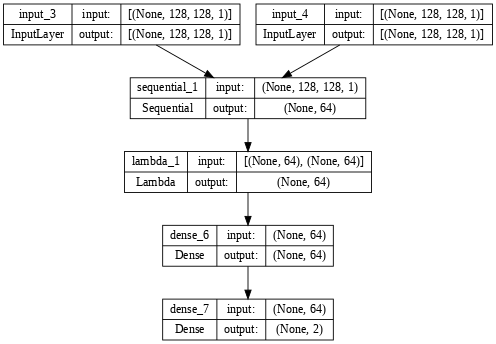

In [ ]:
tf.keras.utils.plot_model(model_discriminator, show_shapes=True, dpi=64)

In [ ]:
validtrain_split_ratio = 0.1  # % of the seen dataset to be put aside for validation, rest is for training
max_epochs = 100  # maxmimum number of epochs to be iterated
batch_size = 128   # batch size for the training data set
lr=0.001
batch_shuffle = True   # shuffle the training data prior to batching before each epoch

model_discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy'])

In [ ]:
# Train the model
history = model_discriminator.fit([pairs_train[:, :, :, 0], pairs_train[:, :, :, 1]], labels_train,
                            batch_size=batch_size,
                            epochs=max_epochs,
                            validation_split=validtrain_split_ratio)


Epoch 1/100
58/58 [==============================] - 8s 81ms/step - loss: 1.2286 - accuracy: 0.4867 - val_loss: 0.9457 - val_accuracy: 0.4877
Epoch 2/100
58/58 [==============================] - 4s 68ms/step - loss: 0.9420 - accuracy: 0.4959 - val_loss: 0.9310 - val_accuracy: 0.5282
Epoch 3/100
58/58 [==============================] - 4s 68ms/step - loss: 0.9270 - accuracy: 0.5041 - val_loss: 0.9175 - val_accuracy: 0.5012
Epoch 4/100
58/58 [==============================] - 4s 66ms/step - loss: 0.9127 - accuracy: 0.5099 - val_loss: 0.9036 - val_accuracy: 0.4951
Epoch 5/100
58/58 [==============================] - 4s 67ms/step - loss: 0.9005 - accuracy: 0.4891 - val_loss: 0.8908 - val_accuracy: 0.5037
Epoch 6/100
58/58 [==============================] - 4s 69ms/step - loss: 0.8858 - accuracy: 0.5133 - val_loss: 0.8790 - val_accuracy: 0.5000
Epoch 7/100
58/58 [==============================] - 4s 67ms/step - loss: 0.8737 - accuracy: 0.5064 - val_loss: 0.8670 - val_accuracy: 0.4988
Epoch 

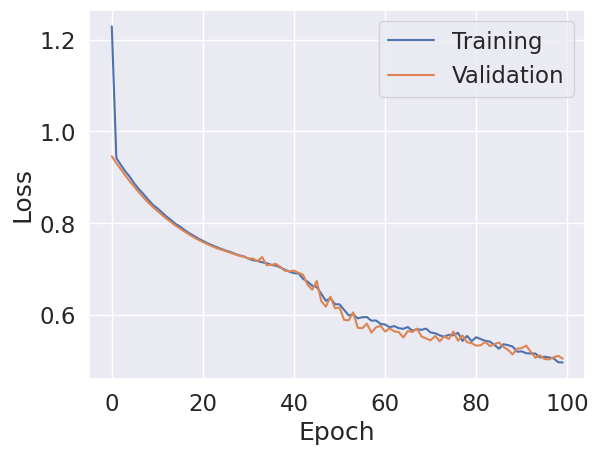

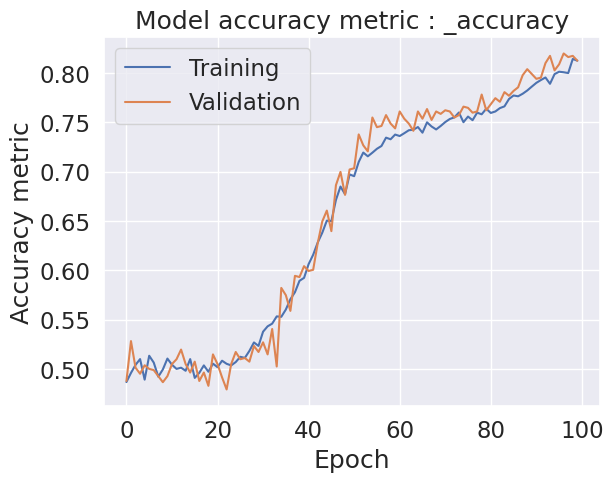

In [ ]:
# model loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.title('Model loss : ' + loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

# model accuracy metric

plt.plot(np.array(history.history['accuracy']))
plt.plot(np.array(history.history['val_' + 'accuracy']))
plt.title('Model accuracy metric : ' + '_accuracy')
plt.ylabel('Accuracy metric')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')
plt.show()
plt.close()

255/255 [==============================] - 1s 5ms/step
test accuracy:  0.6811274509803922
[[0.21385972 0.78888017]
 [0.21513376 0.77861464]
 [0.2749871  0.7000586 ]
 ...
 [0.42427713 0.595932  ]
 [0.15036236 0.8544123 ]
 [0.2886006  0.70566595]]


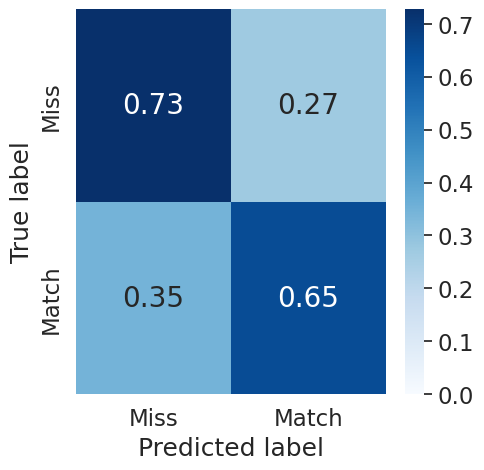

In [ ]:
predicted_labels = model_discriminator.predict([pairs_test[:, :, :, 0], pairs_test[:, :, :, 1]])
print("test accuracy: ", np.sum(np.argmax(predicted_labels, axis=1) == np.argmax(labels_test, axis=1)) / len(labels_test))
print(predicted_labels)

# print confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(np.argmax(predicted_labels, axis=1), np.argmax(labels_test, axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(5,5))
ax = sns.heatmap(cm, annot=True, linewidths=0, square=False, cmap="Blues", yticklabels=['Miss', 'Match'], xticklabels=['Miss', 'Match'], vmin=0, vmax=np.max(cm), fmt=".2f", annot_kws={"size": 20})
ax.set(xlabel='Predicted label', ylabel='True label')

plt.show()


<ipython-input-19-be6cdad6140b>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 10], [0, 0], 'k-', lw=2, color='black')


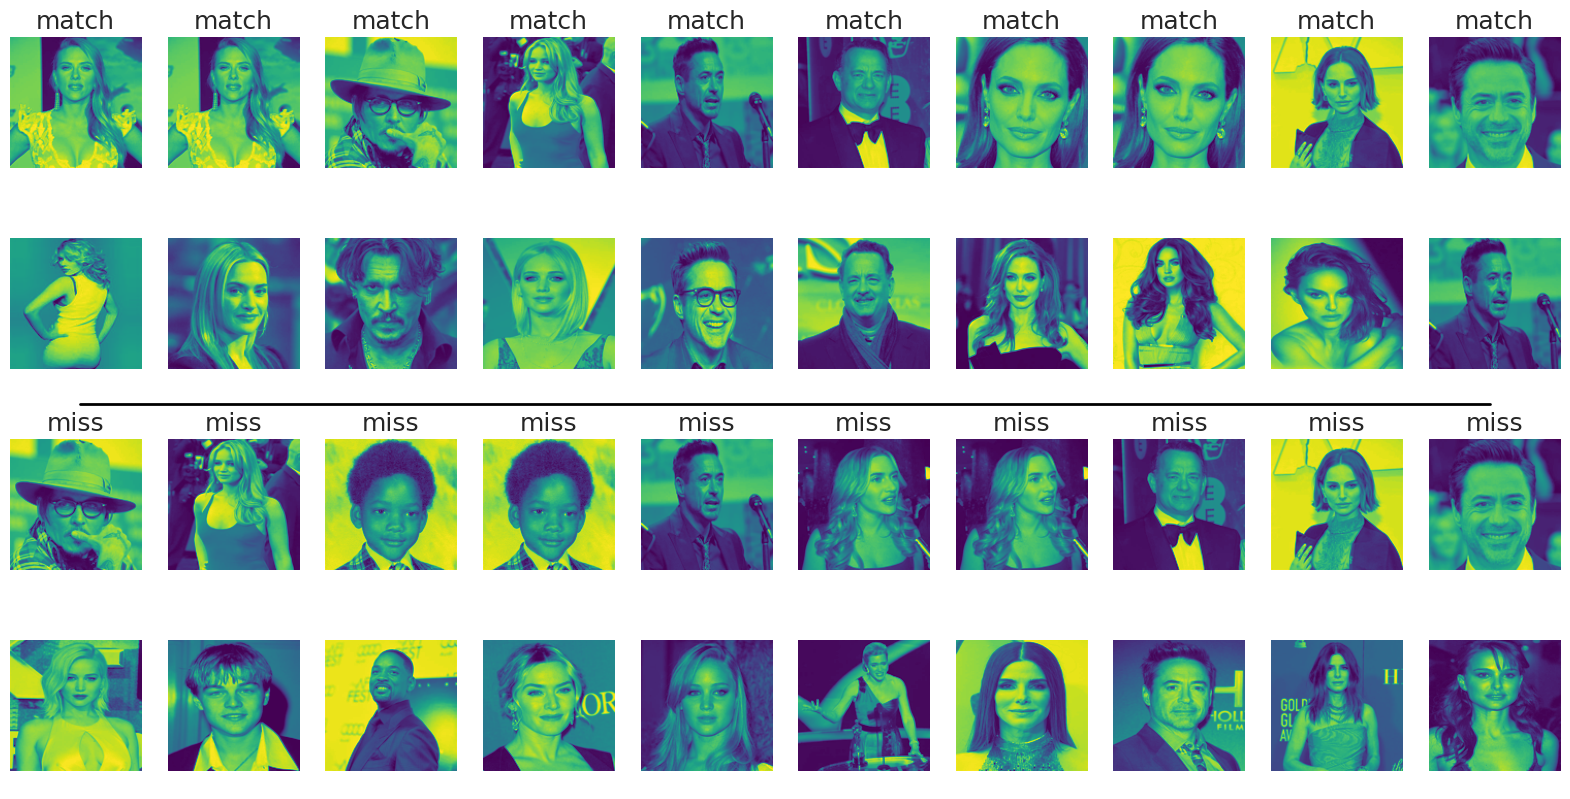

In [ ]:
# Print 10 misses and matches from the test set predicted by the discriminator

pred_matches = np.where(np.argmax(predicted_labels, axis=1) == 1)[0]
pred_misses = np.where(np.argmax(predicted_labels, axis=1) == 0)[0]

fig = plt.figure(figsize=(20, 10))

plt.plot([0, 10], [0, 0], 'k-', lw=2, color='black')
plt.axis('off')

for i in range(10):
    ax = fig.add_subplot(4, 10, i+1)
    ax.imshow(pairs_test[pred_matches[i],:,:,0], cmap='viridis' )
    ax.set_title('match')
    ax.axis('off')
    ax = fig.add_subplot(4, 10, i+11)
    ax.imshow(pairs_test[pred_matches[i],:,:,1], cmap='viridis')
    ax.axis('off')

    ax = fig.add_subplot(4, 10, i+21)
    ax.imshow(pairs_test[pred_misses[i],:,:,0], cmap='viridis')
    ax.set_title('miss')
    ax.axis('off')

    ax = fig.add_subplot(4, 10, i+31)
    ax.imshow(pairs_test[pred_misses[i],:,:,1], cmap='viridis')
    ax.axis('off')


# FaceNET

In [4]:
# Implement a Facenet to cluster this dataset of different people. You can use a convolutional neural network with a structure similar to VGG with the triplet loss.

triplet_loss=tfa.losses.TripletSemiHardLoss()
def network_loss(label,output):
 loss=triplet_loss(label,output)
 return loss

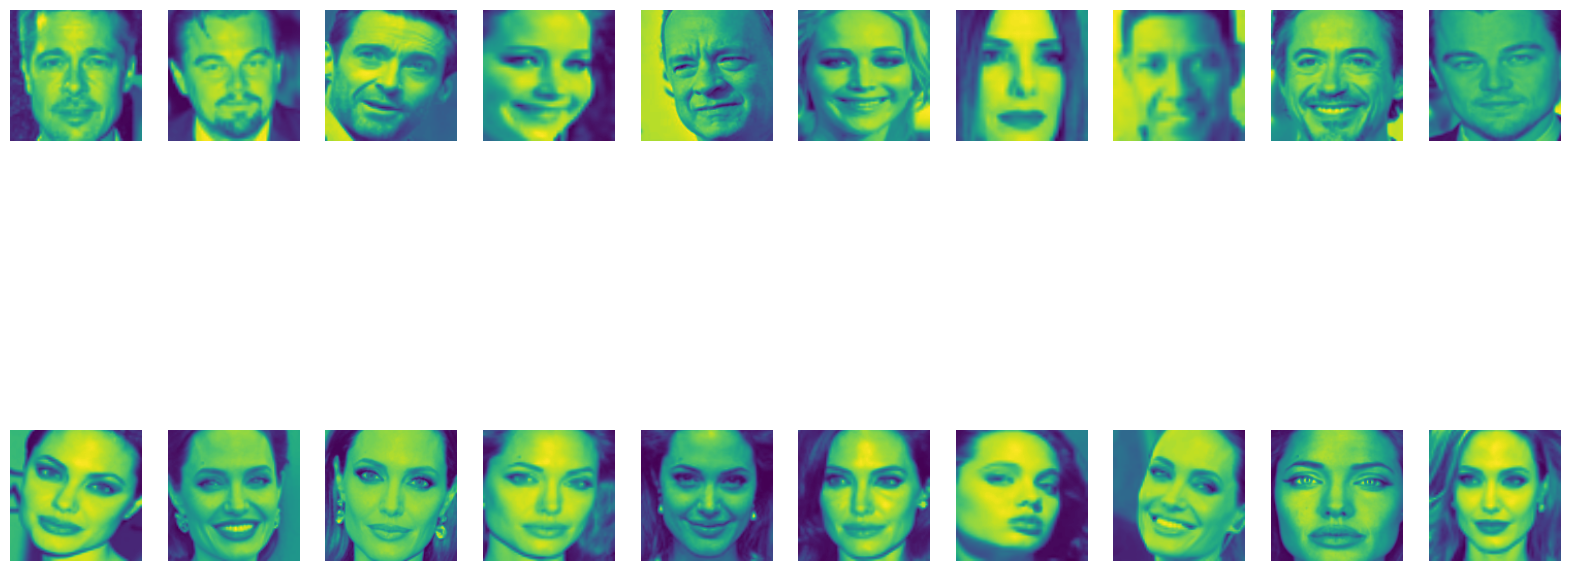

In [5]:
# Use OpenCV to crop the image around the faec and then resize it to 128x128. You can use the following code to do so:

# Imports
import cv2

# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


def crop_resize(img, x, y, w, h):
    # Crop the image around the face
    img = img[y:y+h, x:x+w]
    # Resize the image to 128x128
    img = cv2.resize(img, (128, 128))
    return img

def find_face(img):
    # Find the faces in the image
    faces = face_cascade.detectMultiScale(img, 1.3, 5)
    # If there are no faces in the image, return None
    if len(faces) == 0:
        return None, None
    # If there are multiple faces, return the face with the largest area
    (x, y, w, h) = max(faces, key=lambda face: face[2]*face[3])
    # Return the cropped and resized image
    return crop_resize(img, x, y, w, h), faces[0]

# crop the test and train images

# crop the test images
test_images = []
test_labels = []
for i in range(len(x_test)):
    img = x_test[i]
    face, rect = find_face(img)
    if face is not None:
        test_images.append(face)
        test_labels.append(y_test[i])

# crop the train images
train_images = []
train_labels = []
for i in range(len(x_train)):
    img = x_train[i]
    face, rect = find_face(img)
    if face is not None:
        train_images.append(face)
        train_labels.append(y_train[i])

train_labels = np.array(train_labels)
train_images = np.array(train_images)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Print the first 10 faces 

fig = plt.figure(figsize=(20, 10))

for i in range(10):
    ax = fig.add_subplot(2, 10, i+1)
    ax.imshow(train_images[i], cmap='viridis' )
    ax.axis('off')
    ax = fig.add_subplot(2, 10, i+11)
    ax.imshow(test_images[i], cmap='viridis')
    ax.axis('off')


train_labels_onehot = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
test_labels_onehot = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)


Model: "facenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 256)     2560      
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 256)     590080    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 256)       0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 256)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 128)       295040    
                                                                 
 block3_conv2 (Conv2D)       (None, 64, 64, 128)       1475

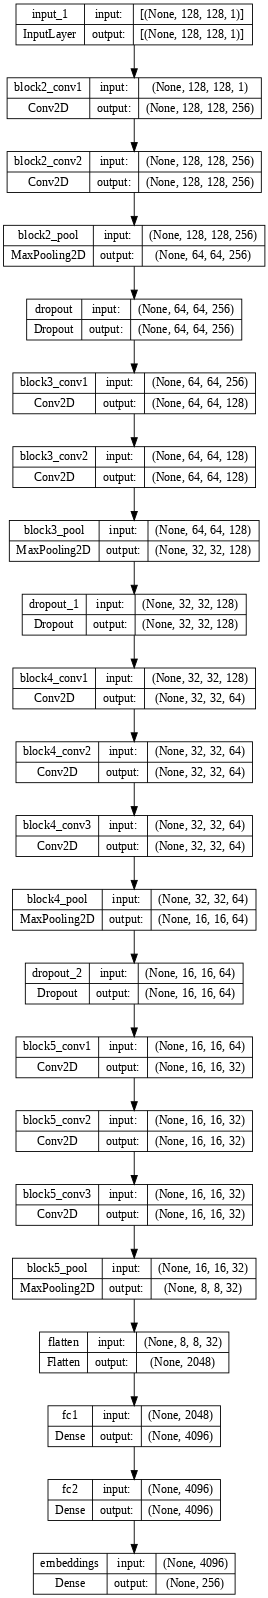

In [7]:
# Define the Facenet model
def facenet(input_shape):
    """
    Implement Facenet using a VGG-like architecture
    """
    # Define the input tensor
    input_tensor = Input(shape=input_shape)

    # Block 1
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block2_conv1')(input_tensor)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block2_pool')(x)
    x = Dropout(0.2)(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block3_pool')(x)
    x = Dropout(0.2)(x)

    # Block 3
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block4_pool')(x)
    x = Dropout(0.2)(x)

    # Block 4
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='block5_pool')(x)

    # Flatten
    x = Flatten(name='flatten')(x)

    # Fully connected layers
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense(256, activation='relu', name='embeddings')(x)

    # Define the model
    model = Model(input_tensor, x, name='facenet')

    return model

model_facenet = facenet(input_shape=(128, 128, 1))

# Print the model summary
model_facenet.summary()

tf.keras.utils.plot_model(model_facenet, show_shapes=True, dpi=64)

In [9]:
validtrain_split_ratio = 0.2  # % of the seen dataset to be put aside for validation, rest is for training
max_epochs = 20  # maxmimum number of epochs to be iterated
batch_size = 64   # batch size for the training data set
batch_shuffle = True   # shuffle the training data prior to batching before each epoch
lr = 0.01

In [12]:
# Compile the model
model_facenet.compile(
    optimizer=Adam(lr = lr),
    loss=network_loss)

In [13]:
# Train the model

history = model_facenet.fit(train_images,train_labels, \
    batch_size=batch_size, \
    epochs=max_epochs, \
    validation_split=validtrain_split_ratio, \
    shuffle=batch_shuffle)

Epoch 1/20
14/14 [==============================] - 62s 2s/step - loss: 1.7099 - val_loss: 0.4334
Epoch 2/20
14/14 [==============================] - 11s 759ms/step - loss: 0.3513 - val_loss: 0.9012
Epoch 3/20
14/14 [==============================] - 10s 736ms/step - loss: 0.5325 - val_loss: 0.4118
Epoch 4/20
14/14 [==============================] - 11s 776ms/step - loss: 0.3841 - val_loss: 0.9744
Epoch 5/20
14/14 [==============================] - 10s 721ms/step - loss: 0.5279 - val_loss: 0.7128
Epoch 6/20
14/14 [==============================] - 10s 720ms/step - loss: 0.5887 - val_loss: 0.6665
Epoch 7/20
14/14 [==============================] - 11s 772ms/step - loss: 0.7984 - val_loss: 0.4105
Epoch 8/20
14/14 [==============================] - 10s 733ms/step - loss: 0.3621 - val_loss: 0.8143
Epoch 9/20
14/14 [==============================] - 11s 780ms/step - loss: 0.5448 - val_loss: 0.3714
Epoch 10/20
14/14 [==============================] - 11s 777ms/step - loss: 0.9981 - val_loss:

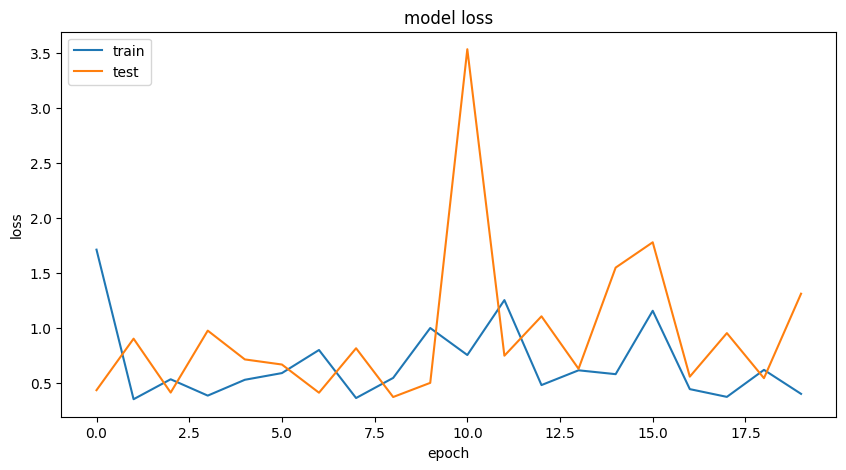

In [14]:
# Plot the training and validation accuracy and loss at each epoch
fig, (ax2) = plt.subplots(1, 1, figsize=(10, 5))

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')

ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')

plt.show()

In [15]:
# A fully connected neural network to classify the output of the network.

# Create the model
model_classifier = tf.keras.Sequential()

# Add the fully connected layers
model_classifier.add(Dense(4096, activation='relu', input_shape=(256,)))
model_classifier.add(Dense(2056, activation='relu'))

# Add the output layer
model_classifier.add(Dense(num_classes, activation='softmax'))

In [16]:
# Evaluate the network
FN_output = model_facenet.predict(train_images)

print(FN_output.shape)
print(output_train_class_onehot.shape)
print(model_classifier.input_shape)
print(model_classifier.output_shape)

35/35 [==============================] - 8s 118ms/step
(1098, 256)
(1360, 17)
(None, 256)
(None, 17)


In [17]:
validtrain_split_ratio = 0.2  # % of the seen dataset to be put aside for validation, rest is for training
max_epochs = 200  # maxmimum number of epochs to be iterated
batch_size = 128   # batch size for the training data set
batch_shuffle = True   # shuffle the training data prior to batching before each epoch
lr = 0.0001

# Compile the model
model_classifier.compile(
    optimizer=Adam(lr),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


In [18]:
# Train the network
history = model_classifier.fit(FN_output, train_labels_onehot, \
    batch_size=batch_size, \
    epochs=max_epochs, \
    validation_split=validtrain_split_ratio, \
    shuffle=batch_shuffle)

Epoch 1/200
7/7 [==============================] - 2s 41ms/step - loss: 27.4866 - accuracy: 0.0752 - val_loss: 27.3535 - val_accuracy: 0.1000
Epoch 2/200
7/7 [==============================] - 0s 15ms/step - loss: 31.7584 - accuracy: 0.1025 - val_loss: 28.6014 - val_accuracy: 0.0864
Epoch 3/200
7/7 [==============================] - 0s 14ms/step - loss: 25.2251 - accuracy: 0.0957 - val_loss: 20.6850 - val_accuracy: 0.1000
Epoch 4/200
7/7 [==============================] - 0s 16ms/step - loss: 19.0422 - accuracy: 0.0934 - val_loss: 16.3747 - val_accuracy: 0.0636
Epoch 5/200
7/7 [==============================] - 0s 13ms/step - loss: 13.6911 - accuracy: 0.1036 - val_loss: 10.6449 - val_accuracy: 0.0955
Epoch 6/200
7/7 [==============================] - 0s 12ms/step - loss: 9.0907 - accuracy: 0.0820 - val_loss: 7.9185 - val_accuracy: 0.1227
Epoch 7/200
7/7 [==============================] - 0s 14ms/step - loss: 6.7176 - accuracy: 0.1093 - val_loss: 5.6251 - val_accuracy: 0.1136
Epoch 8/20

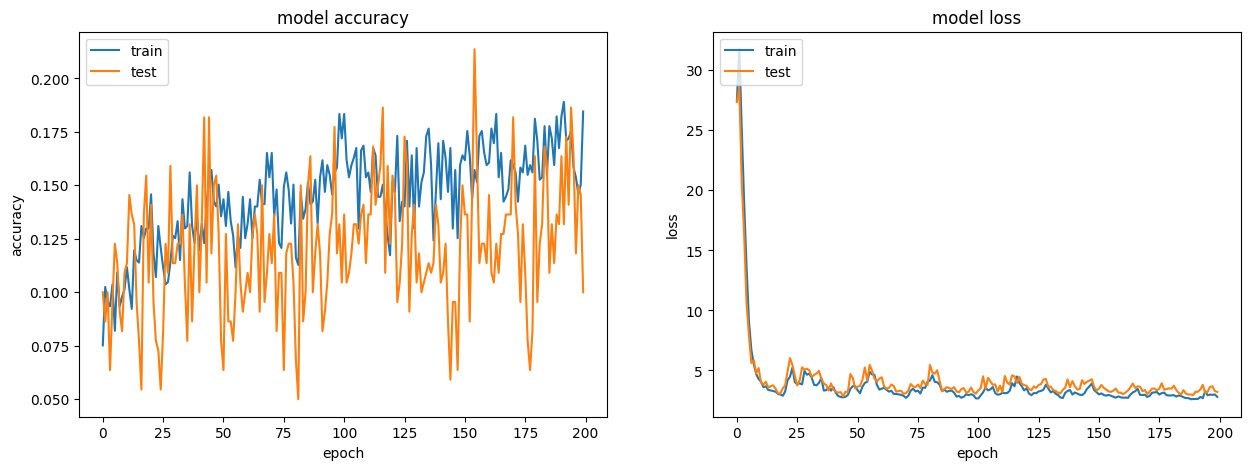

In [19]:
# Plot the training and validation accuracy and loss at each epoch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')

ax1.legend(['train', 'test'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')

plt.show()

In [20]:
# Evaluate the network
test_FN_output = model_facenet.predict(test_images)
predictions = model_classifier.predict(test_FN_output)

print(predictions.shape)

predictions = np.argmax(predictions, axis=1)
print(predictions.shape)
predictions = predictions + 1

9/9 [==============================] - 0s 2ms/step
(266, 17)
(266,)


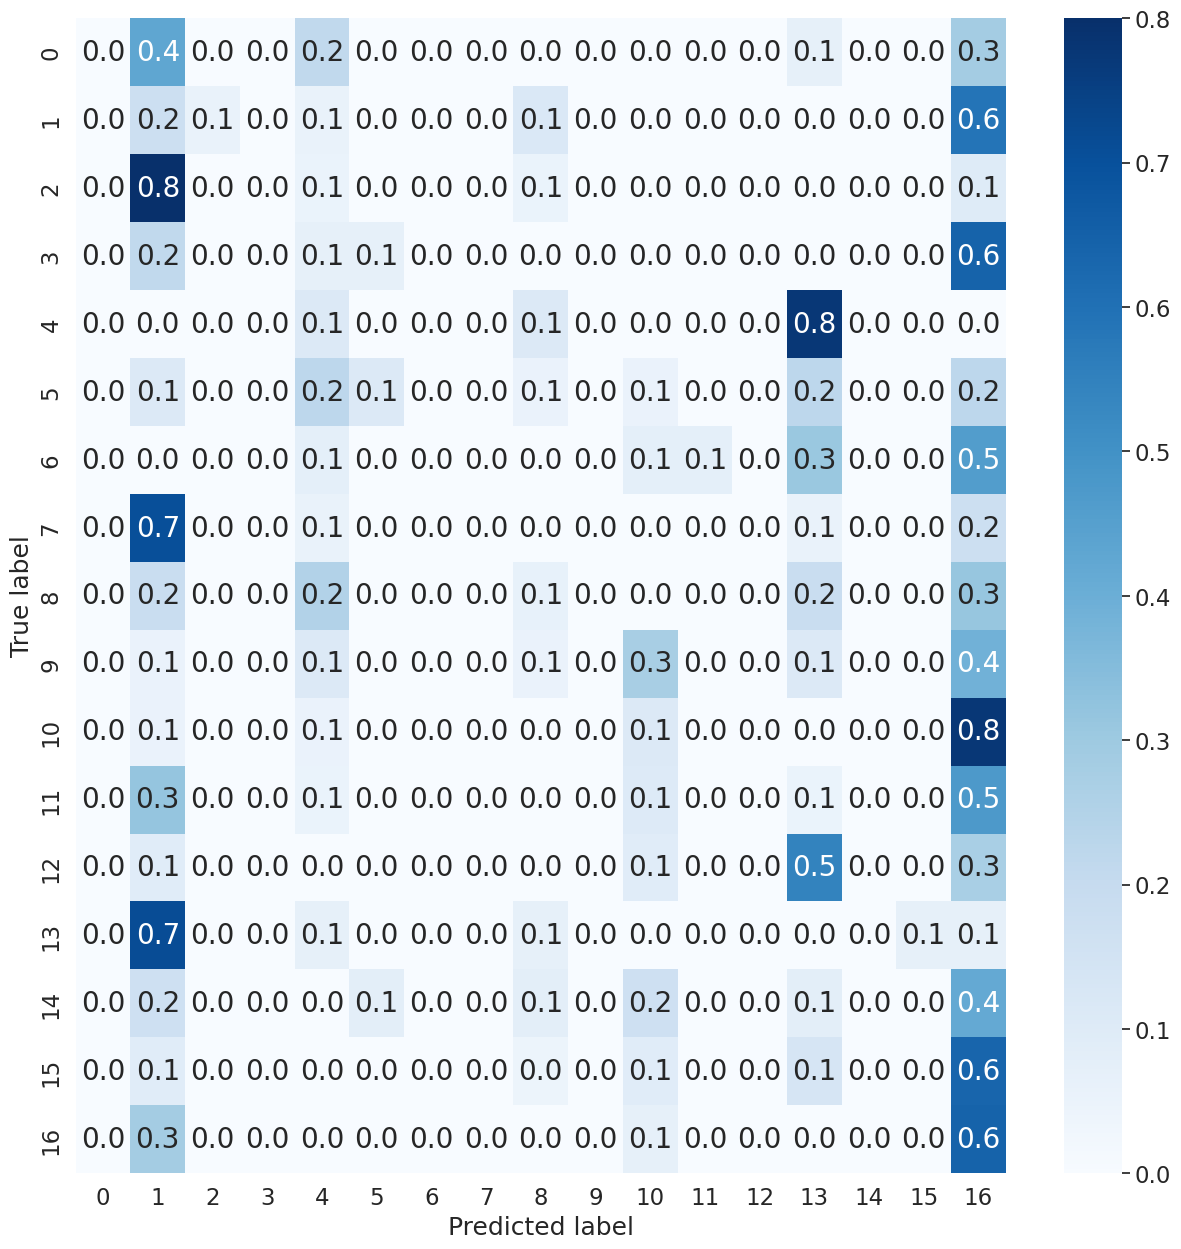

In [25]:
# print the confusion matrix in a pretty graph
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, predictions)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(cm, annot=True, linewidths=0, square=False, cmap="Blues", yticklabels=range(num_classes), xticklabels=range(num_classes), vmin=0, vmax=np.max(cm), fmt=".1f", annot_kws={"size": 20})
ax.set(xlabel='Predicted label', ylabel='True label')

plt.show()

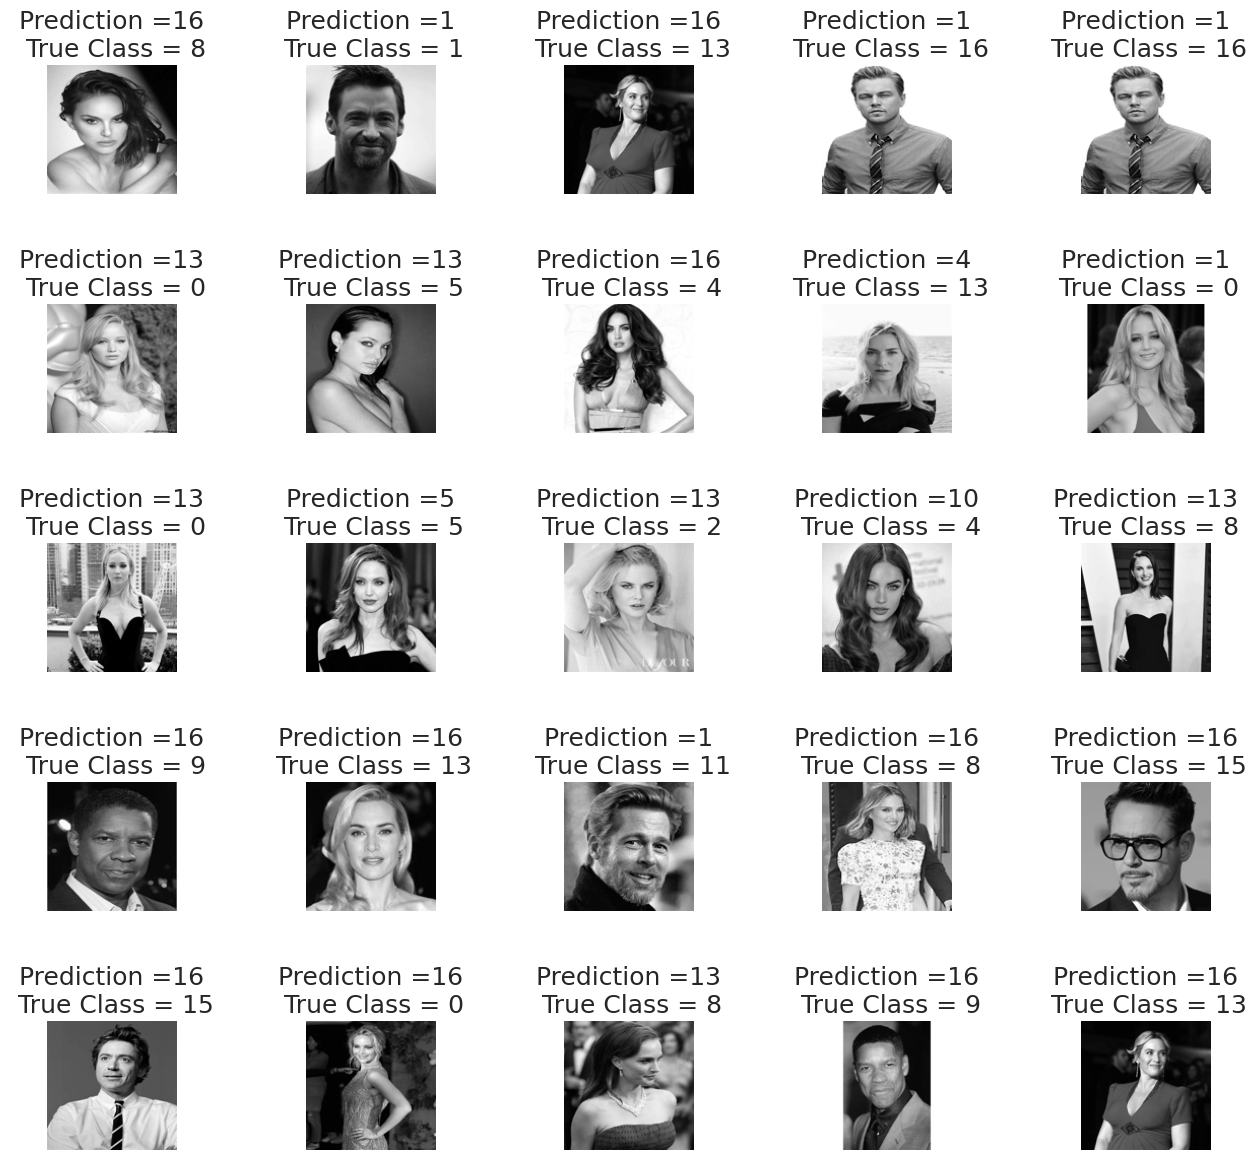

In [26]:

# Plot the images with the predicted and actual labels
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.ravel()

for i, k in enumerate(np.random.randint(0, len(predictions), size=25)):
    axes[i].imshow(x_test[k].reshape(128, 128), cmap='gray')
    axes[i].set_title("Prediction ={}\n True Class = {}".format(predictions[k], y_test[k]))
    axes[i].axis('off')

plt.subplots_adjust(wspace=1)